In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler

from autosklearn.regression import AutoSklearnRegressor

import os

%matplotlib inline

### Data ingestion

In [2]:
data = pd.read_csv('../../data/bengaluru_house_prices.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB
None


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [22]:
data.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


In [3]:
#split into train and test
train_df, test_df = train_test_split(data, test_size=0.2, random_state=10)
print(train_df.shape)
print(test_df.shape)

(10656, 9)
(2664, 9)


### Data analysis

In [4]:
data['availability'].value_counts()
# we can create features from this - ready_to_move 1 or 0 and see if any relationship exist with price

Ready To Move    10581
18-Dec             307
18-May             295
18-Apr             271
18-Aug             200
                 ...  
15-Aug               1
17-Jan               1
16-Nov               1
16-Jan               1
14-Jul               1
Name: availability, Length: 81, dtype: int64

In [5]:
data['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

In [6]:
data['location'].value_counts()

Whitefield                        540
Sarjapur  Road                    399
Electronic City                   302
Kanakpura Road                    273
Thanisandra                       234
                                 ... 
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
singapura paradise                  1
Abshot Layout                       1
Name: location, Length: 1305, dtype: int64

In [7]:
data['size'].value_counts()
# create three features from this bedroom, hall, kitchen

2 BHK         5199
3 BHK         4310
4 Bedroom      826
4 BHK          591
3 Bedroom      547
1 BHK          538
2 Bedroom      329
5 Bedroom      297
6 Bedroom      191
1 Bedroom      105
8 Bedroom       84
7 Bedroom       83
5 BHK           59
9 Bedroom       46
6 BHK           30
7 BHK           17
1 RK            13
10 Bedroom      12
9 BHK            8
8 BHK            5
11 BHK           2
11 Bedroom       2
10 BHK           2
14 BHK           1
13 BHK           1
12 Bedroom       1
27 BHK           1
43 Bedroom       1
16 BHK           1
19 BHK           1
18 Bedroom       1
Name: size, dtype: int64

In [8]:
data.isnull().sum()
# we will fill up 
#     balcony with Unknown,
#     society with Not Given, 
#     bath with 1, and
#     bedroom, hall and kitchen with the mean of its location
#     delete anyother na

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

# Feature Engineering

In [9]:
df = train_df.copy()

encoder_initialized = False

def feature_engineering(df):
    def fix_total_sqft(tsqf):
        mul = 1
        if 'Sq. Yards' in tsqf:
            mul = 9
        elif 'Sq. Meter' in tsqf:
            mul = 10.763910
        elif 'Acres' in tsqf:
            mul = 43560
        elif 'Guntha' in tsqf:
            mul = 1089
        elif 'Grounds' in tsqf:
            mul = 2400
        elif 'Cents' in tsqf:
            mul = 435.56
        else:
            mul = 1
        tsqf = tsqf.replace('Sq. Meter', '').replace('Perch', '').replace('Sq. Yards', ''). \
                    replace('Cents', '').replace('Acres', '').replace('Guntha', '').replace('Grounds', '')
        parts = tsqf.split(' - ')
        return float(parts[0])

    def break_into_bedroom_hall_and_kitchen(s):
        if s is None or np.nan == s:
            return pd.Series([np.nan, np.nan, np.nan])
        parts = str(s).split(' ')
        if parts[0] == 'nan':
            return pd.Series([np.nan, np.nan, np.nan])
        number_part = int(parts[0])
        if parts[1] == 'BHK':
            return pd.Series([number_part, number_part, number_part]).astype(int)
        elif parts[1] == 'HK':
            return pd.Series([0, number_part, number_part]).astype(int)
        elif parts[1] == 'Bedroom':
            return pd.Series([number_part, 0, 0]).astype(int)
        else:
            return pd.Series([np.nan, np.nan, np.nan])

    # society
    df['bath'].fillna(1, inplace=True)
    df['society'].fillna('Not Given', inplace=True)
    df['balcony'].fillna(0, inplace=True)
    # availability
    if 'availability' in df.columns:
        df.loc[df['availability'] == 'Ready To Move','ready_to_move'] = 1
        df.loc[df['availability'] != 'Ready To Move','ready_to_move'] = 0
    # total_sqft
    df['total_sqft'] = df['total_sqft'].apply(fix_total_sqft)
    # size
    if 'size' in df.columns:
        df[['bedroom', 'hall', 'kitchen']] = df['size'].apply(break_into_bedroom_hall_and_kitchen)

    df.drop(['availability', 'size'], axis=1, inplace=True)
    df = df.dropna()
#     print("na/null values ", df.isna().values.sum())

    if not encoder_initialized:
        society_label_encoder = LabelEncoder().fit(df['society'])
        area_type_label_encoder = LabelEncoder().fit(df['area_type'])
        location_label_encoder = LabelEncoder().fit(df['location'])
        encoder_initialize = True
    
    # area type
    df['area_type'] = area_type_label_encoder.transform(df['area_type'])
    # society
    df['society'] = society_label_encoder.transform(df['society'])
    # location
    df['location'] = location_label_encoder.transform(df['location'])
    
    return df

df = feature_engineering(df)
df.head()

/tmp/ipykernel_1494/1644048058.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['area_type'] = area_type_label_encoder.transform(df['area_type'])
/tmp/ipykernel_1494/1644048058.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['society'] = society_label_encoder.transform(df['society'])
/tmp/ipykernel_1494/1644048058.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,area_type,location,society,total_sqft,bath,balcony,price,ready_to_move,bedroom,hall,kitchen
3875,3,624,443,1149.0,2.0,2.0,29.00,0.0,3.0,3.0,3.0
7004,3,1075,1241,1255.0,2.0,3.0,50.19,1.0,3.0,3.0,3.0
6286,2,1144,1241,1200.0,2.0,1.0,46.13,0.0,2.0,0.0,0.0
2887,3,453,1479,1850.0,3.0,0.0,110.00,1.0,3.0,3.0,3.0
7746,3,60,1241,1100.0,2.0,3.0,35.00,1.0,2.0,2.0,2.0


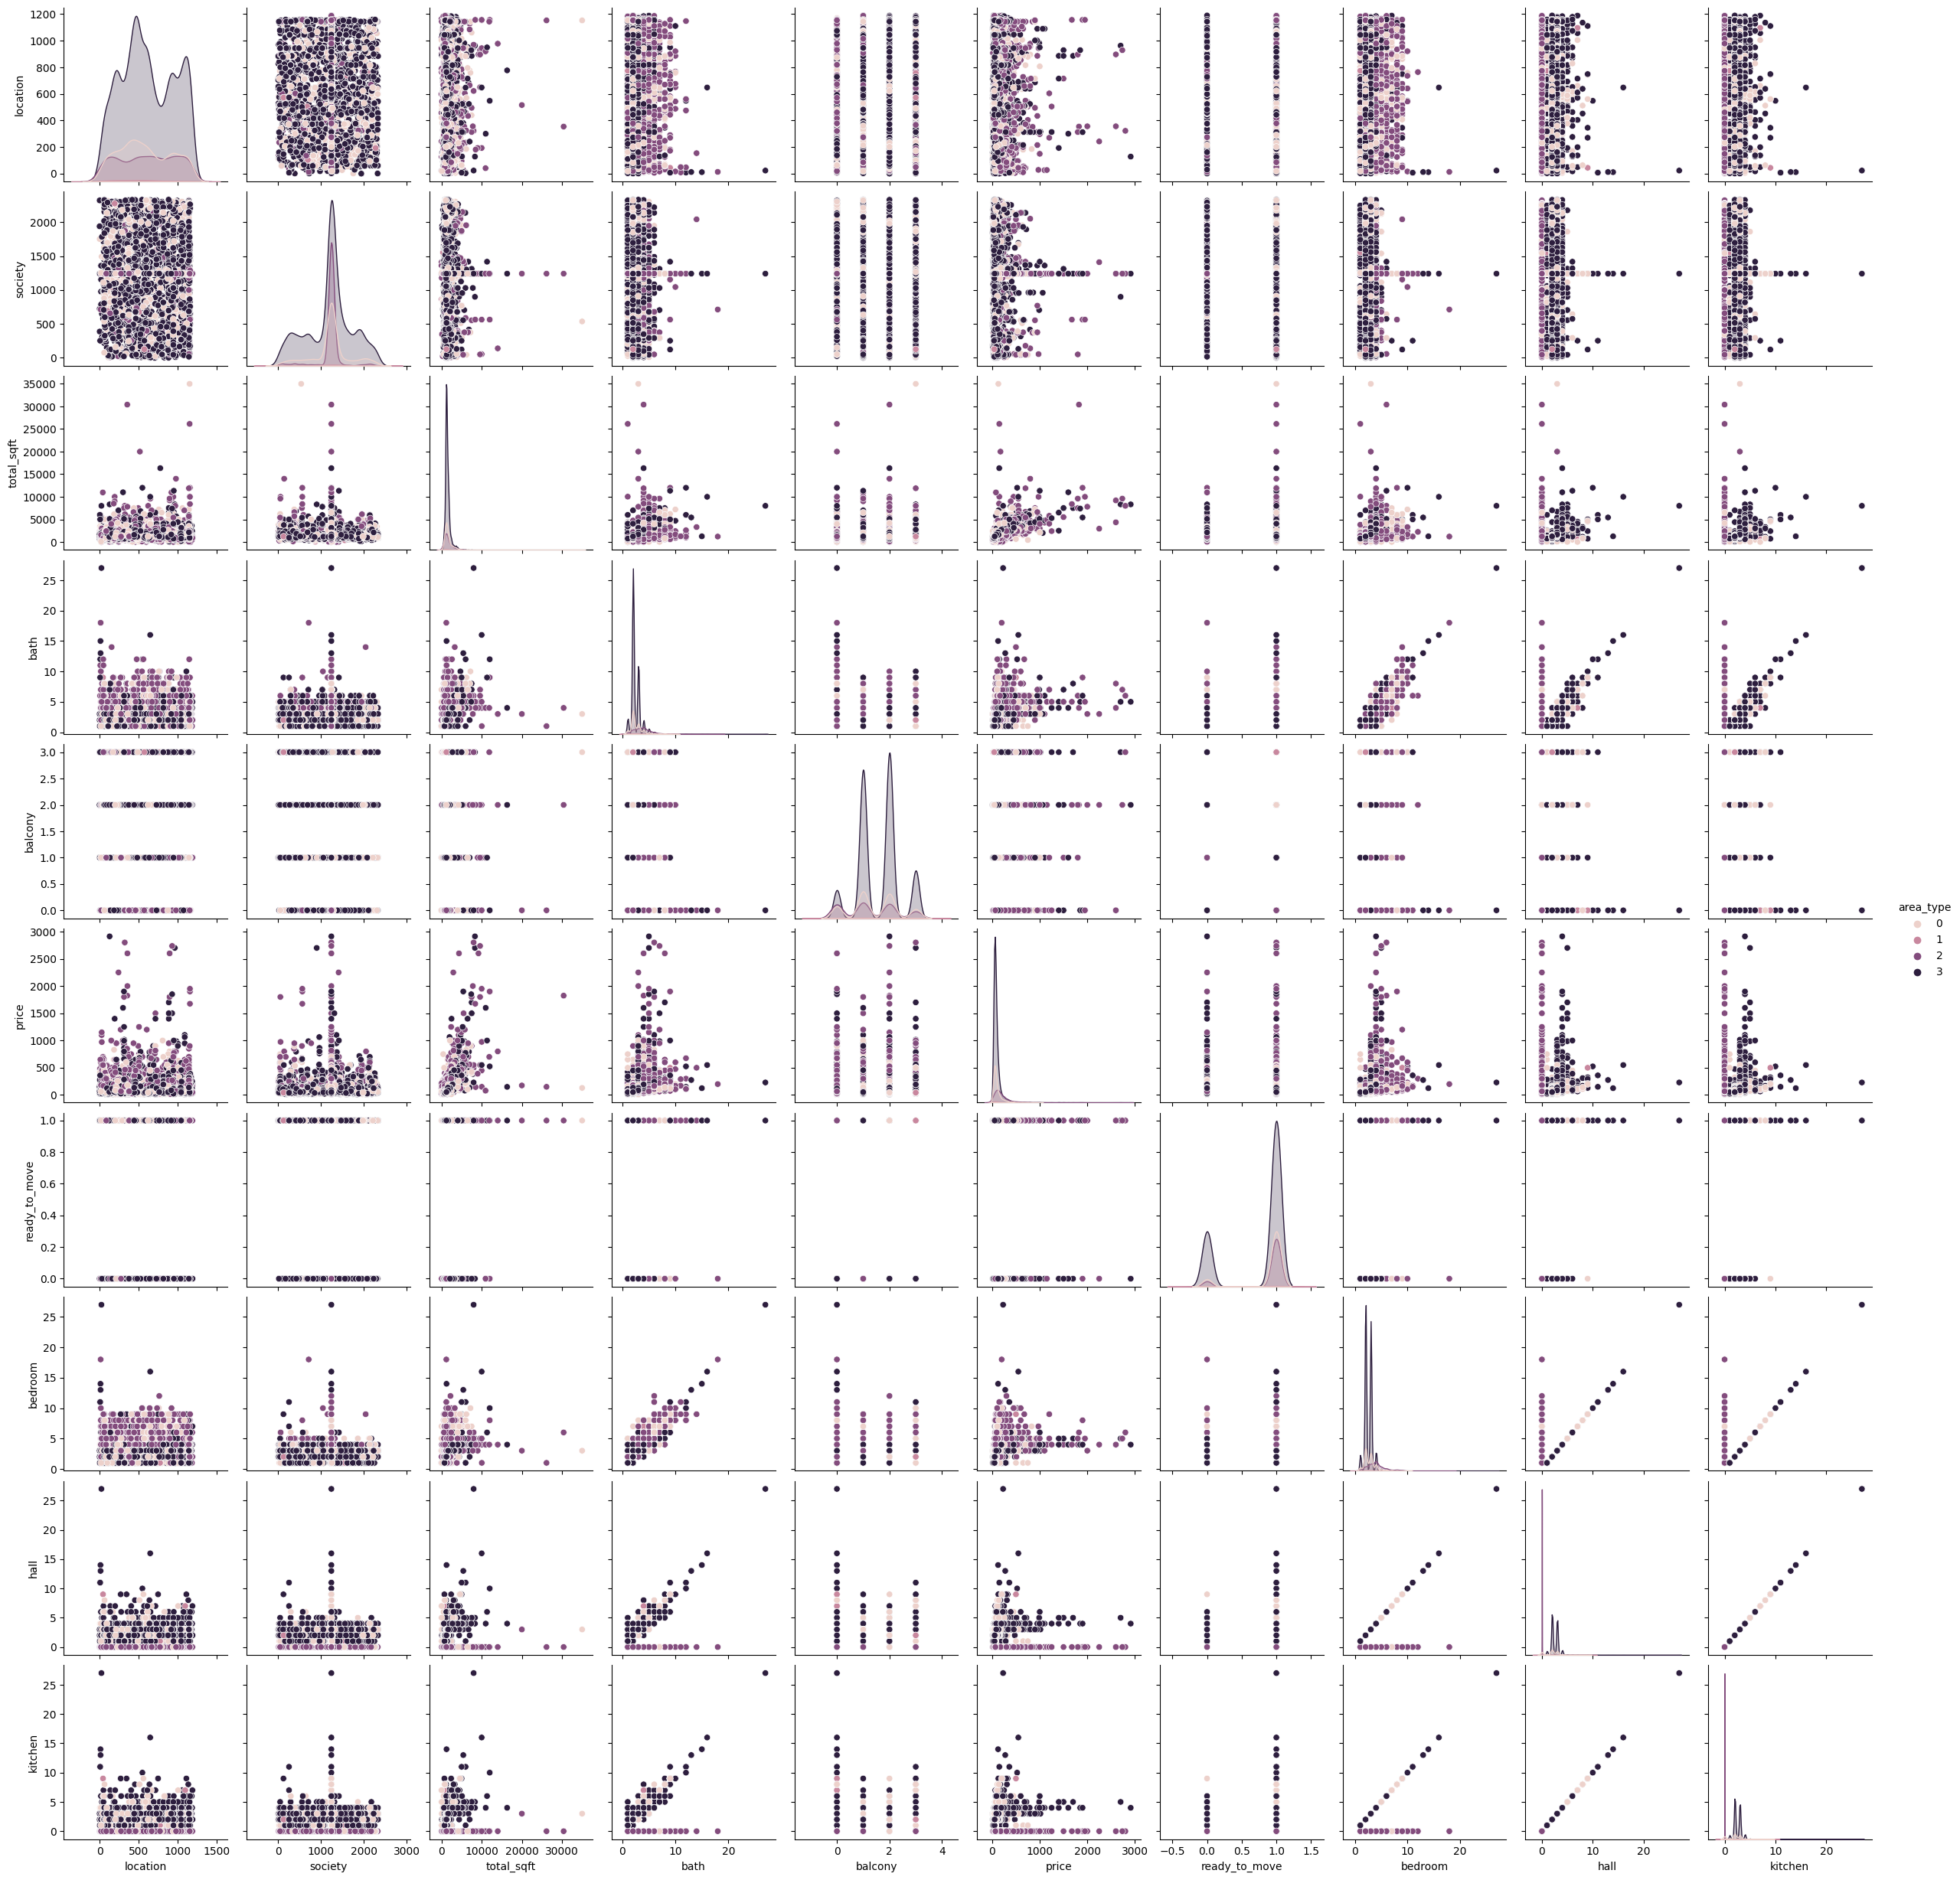

In [10]:
sns.pairplot(df, hue='area_type');

In [11]:
y_train = df['price']
X_train = df.drop(['price'], axis=1)

automl = AutoSklearnRegressor().fit(X_train, y_train)

In [18]:
automl.leaderboard(detailed=True, top_k=20)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
70,1,0.02,mlp,0.421684,16.510170,69,0.384743,0,1.685460e+09,1.685460e+09,0.0,StatusType.SUCCESS,[],[extra_trees_preproc_for_regression],None,Local Search
8,2,0.26,mlp,0.421807,9.071595,7,0.361396,0,1.685458e+09,1.685458e+09,0.0,StatusType.SUCCESS,[],[extra_trees_preproc_for_regression],None,Initial design
53,3,0.02,random_forest,0.449114,244.461590,52,0.244721,0,1.685460e+09,1.685460e+09,0.0,StatusType.SUCCESS,[],[random_trees_embedding],None,Random Search
12,4,0.20,gradient_boosting,0.475562,11.386042,11,0.015759,0,1.685458e+09,1.685458e+09,0.0,StatusType.SUCCESS,[],[polynomial],None,Initial design
62,5,0.18,mlp,0.488631,3.006460,61,0.246272,0,1.685460e+09,1.685460e+09,0.0,StatusType.SUCCESS,[],[polynomial],None,Local Search
76,6,0.18,adaboost,0.495679,3.603345,75,0.105464,0,1.685460e+09,1.685460e+09,0.0,StatusType.SUCCESS,[],[extra_trees_preproc_for_regression],None,Random Search
4,7,0.06,k_nearest_neighbors,0.529310,0.885398,3,0.000466,0,1.685457e+09,1.685457e+09,0.0,StatusType.SUCCESS,[],[select_rates_regression],None,Initial design
7,8,0.06,gradient_boosting,0.531411,3.477093,6,0.023109,0,1.685458e+09,1.685458e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],None,Initial design
72,9,0.02,adaboost,0.585665,17.737683,71,0.238364,0,1.685460e+09,1.685460e+09,0.0,StatusType.SUCCESS,[],[random_trees_embedding],None,Random Search


In [37]:
automl.sprint_statistics()

'auto-sklearn results:\n  Dataset name: 90ef7bd0-fef7-11ed-85d6-0242ac110002\n  Metric: r2\n  Best validation score: 0.578316\n  Number of target algorithm runs: 87\n  Number of successful target algorithm runs: 81\n  Number of crashed target algorithm runs: 0\n  Number of target algorithms that exceeded the time limit: 3\n  Number of target algorithms that exceeded the memory limit: 3\n'

In [23]:
y_train_pred = automl.predict(X_train)
print(f'Mean absolute error is {round(mean_absolute_error(y_train, y_train_pred), 4)}')
print(f'Mean absolute percentage error is {round(mean_absolute_percentage_error(y_train, y_train_pred), 4)}')
print(f'Mean square error is {round(mean_squared_error(y_train, y_train_pred), 4)}')
print(f'Root mean square error is {round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 4)}')
print(f'R2 score is {round(r2_score(y_train, y_train_pred), 4)}')

Mean absolute error is 25.8816
Mean absolute percentage error is 0.2512
Mean square error is 3854.7613
Root mean square error is 62.0867
R2 score is 0.8136


## Testing and evaluation

In [19]:
test_df = feature_engineering(test_df)
y_test = test_df['price']
X_test = test_df.drop(['price'], axis=1)

y_pred = automl.predict(X_test)

/tmp/ipykernel_1494/1644048058.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bath'].fillna(1, inplace=True)
/tmp/ipykernel_1494/1644048058.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['society'].fillna('Not Given', inplace=True)
/tmp/ipykernel_1494/1644048058.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['balcony'].fillna(0, inplace=True)
/tmp/ipykernel_1494/1644048058.py:49: SettingWithCopyWarning: 
A v

In [20]:
print(f'Mean absolute error is {round(mean_absolute_error(y_test, y_pred), 4)}')
print(f'Mean absolute percentage error is {round(mean_absolute_percentage_error(y_test, y_pred), 4)}')
print(f'Mean square error is {round(mean_squared_error(y_test, y_pred), 4)}')
print(f'Root mean square error is {round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)}')
print(f'R2 score is {round(r2_score(y_test, y_pred), 4)}')


Mean absolute error is 39.798
Mean absolute percentage error is 0.3234
Mean square error is 13049.0321
Root mean square error is 114.2324
R2 score is 0.5393


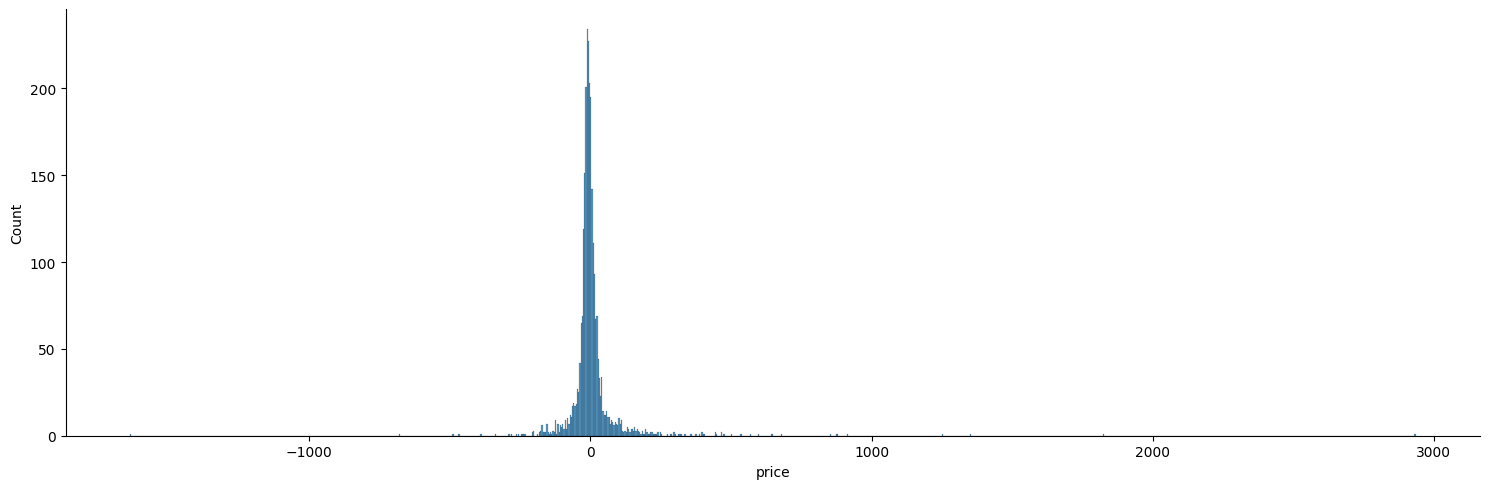

In [21]:
y_error = y_test - y_pred
sns.displot(y_error, height=5, aspect=3, kind='hist');